In [1]:
import xml.etree.ElementTree as ET
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime

In [2]:
# create element tree object
tree = ET.parse('apple_health_export/export.xml')

In [3]:
# for every health record, extract the attributes into a dictionary (columns). Then create a list (rows).
root = tree.getroot()
record_list = [x.attrib for x in root.iter('Record')]

In [4]:
# create DataFrame from a list (rows) of dictionaries (columns)
data = pd.DataFrame(record_list)
#print(data)

In [5]:
# proper type to dates
for col in ['creationDate', 'startDate', 'endDate']:
    data[col] = pd.to_datetime(data[col])
#print(data)

In [6]:
# value is numeric, NaN if fails
data['value'] = pd.to_numeric(data['value'], errors='coerce')

In [7]:
# some records do not measure anything, just count occurences
# filling with 1.0 (= one time) makes it easier to aggregate
data['value'] = data['value'].fillna(1.0)

In [8]:
# shorter observation names: use vectorized replace function
data['type'] = data['type'].str.replace('HKQuantityTypeIdentifier', '')
data['type'] = data['type'].str.replace('HKCategoryTypeIdentifier', '')
data['type'] = data['type'].str.replace('HKDataType', '')

In [9]:
# What data looks like

# rows x columns
print("Shape:", data.shape)
# all column names
print("Columns:", data.columns)
# all data types
types = data.type.unique()
print("Types:", len(types), '\n', types)
# data sources
sources = data.sourceName.unique()
print("Sources:", len(sources), '\n', sources)

Shape: (284034, 9)
Columns: Index(['type', 'sourceName', 'sourceVersion', 'unit', 'creationDate',
       'startDate', 'endDate', 'value', 'device'],
      dtype='object')
Types: 32 
 ['DietaryWater' 'Height' 'BodyMass' 'HeartRate' 'RespiratoryRate'
 'StepCount' 'DistanceWalkingRunning' 'BasalEnergyBurned'
 'ActiveEnergyBurned' 'FlightsClimbed' 'AppleExerciseTime'
 'RestingHeartRate' 'WalkingHeartRateAverage' 'EnvironmentalAudioExposure'
 'HeadphoneAudioExposure' 'WalkingDoubleSupportPercentage'
 'AppleStandTime' 'WalkingSpeed' 'WalkingStepLength'
 'WalkingAsymmetryPercentage' 'StairAscentSpeed' 'StairDescentSpeed'
 'SleepDurationGoal' 'AppleWalkingSteadiness'
 'AppleSleepingWristTemperature' 'TimeInDaylight' 'PhysicalEffort'
 'SleepAnalysis' 'AppleStandHour' 'HighHeartRateEvent'
 'AudioExposureEvent' 'HeartRateVariabilitySDNN']
Sources: 4 
 ['WaterMinder' 'Health' 'Mihir’s Apple\xa0Watch' 'TheOneIphone']


In [10]:
# pivot and resample
# body mass and total walking distance
pivot_df = data.pivot_table(index='endDate', columns='type', values='value')
print(pivot_df)

type                       ActiveEnergyBurned  AppleExerciseTime  \
endDate                                                            
2015-03-02 20:01:32-06:00                 NaN                NaN   
2015-03-02 20:01:34-06:00                 NaN                NaN   
2015-03-02 20:01:37-06:00                 NaN                NaN   
2015-03-02 20:01:40-06:00                 NaN                NaN   
2015-03-02 20:01:42-06:00                 NaN                NaN   
...                                       ...                ...   
2024-12-30 13:39:25-06:00               0.236                NaN   
2024-12-30 13:43:53-06:00                 NaN                NaN   
2024-12-30 13:44:38-06:00                 NaN                NaN   
2024-12-30 13:49:22-06:00               1.631                NaN   
2024-12-30 14:00:00-06:00                 NaN                NaN   

type                       AppleSleepingWristTemperature  AppleStandHour  \
endDate                                

type                       HeartRate
endDate                             
2015-03-02 00:00:00-06:00        NaN
2015-03-03 00:00:00-06:00        NaN
2015-03-04 00:00:00-06:00        NaN
2015-03-05 00:00:00-06:00        NaN
2015-03-06 00:00:00-06:00        NaN
...                              ...
2024-12-26 00:00:00-06:00  85.742420
2024-12-27 00:00:00-06:00  77.617457
2024-12-28 00:00:00-06:00  86.224374
2024-12-29 00:00:00-06:00  80.744144
2024-12-30 00:00:00-06:00  74.220617

[3592 rows x 1 columns]


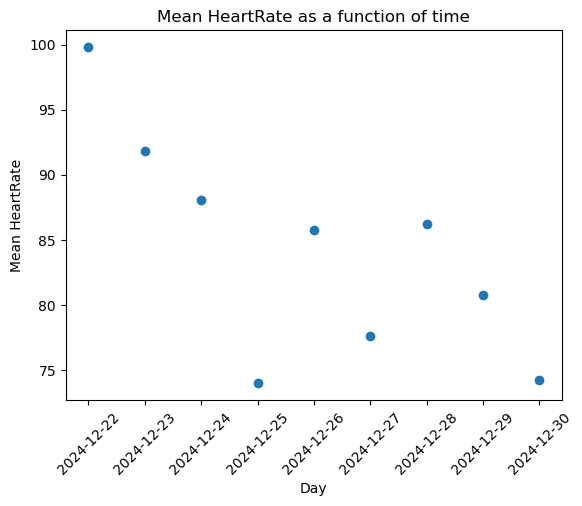

In [54]:
df = pivot_df.resample('D').agg({'HeartRate' : "mean"})
print(df)

# set data
x = df.index
y = df['HeartRate']

# configure scatterplot
plt.scatter(x, y)

# rename x-axis data labels
labels = df.dropna().index    # drop rows with NaN
labels = [str(date).split(' ')[0] for date in labels]
plt.xticks(df.dropna().index, labels, rotation=45)

# set x and y-axis labels
plt.xlabel('Day')
plt.ylabel('Mean HeartRate')
plt.title('Mean HeartRate as a function of time')
plt.show()
#plt.savefig("Mean HeartRate")    # to save, comment out plt.show()

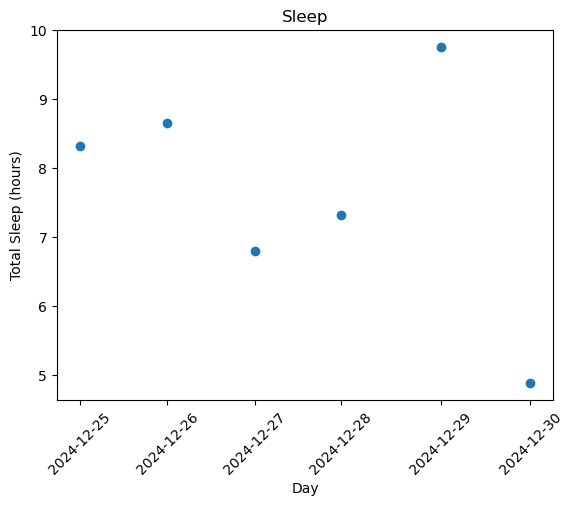

In [63]:
# filter on sleep data and apple watch info ONLY
sleep_data = data[data['type'] == "SleepAnalysis"]
sleep_data = sleep_data[sleep_data['sourceName'] == 'Mihir’s Apple\xa0Watch']
#print(sleep_data)

# calulate time between date(s)
sleep_data['time_asleep'] = sleep_data['endDate'] - sleep_data['startDate']
#print(sleep_data['time_asleep'])
# records are grouped by creation date, so lets used that to sum up the values we need here
# total time asleep as a sum of the asleep time
# awake and bed times are max's and min's
# sleep count is the number of times the Apple Watch detected movement
# rem is the number of sleep cycles over 90 minutes (divded by 90 if they were longer than 1 cycle)
sleep_data = sleep_data.groupby('creationDate').agg(total_time_asleep=('time_asleep', 'sum'),
    bed_time=('startDate', 'min'), 
    awake_time=('endDate', 'max'), 
    sleep_counts=('creationDate','count'), 
    rem_cycles=pd.NamedAgg(column='time_asleep', aggfunc=lambda x: (x // datetime.timedelta(minutes=90)).sum()))

# Time in Bed will be different to Apple's reported figure - 
# as Apple uses the time you place your iPhone down as an additional 
# datapoint, which of course, is incorrect if you try to maintain 
# some device separation in the evenings.
# For now - we will just use Apple Watch data here
sleep_data['time_in_bed'] = sleep_data['awake_time'] - sleep_data['bed_time']
sleep_data['restless_time'] = sleep_data['time_in_bed'] - sleep_data['total_time_asleep']

# convert time duration to hours for easier plotting and comparison
# time in bed and total time asleep seem to be exactly the same for me
sleep_data['time_in_bed'] = (sleep_data['time_in_bed'].dt.total_seconds()/60/60)
sleep_data['total_time_asleep'] = (sleep_data['total_time_asleep'].dt.total_seconds()/60/60)

#chart1 = sleep_data[['time_in_bed','total_time_asleep']].plot(use_index=True)
plt.scatter(sleep_data.index, sleep_data['total_time_asleep'])
plt.xticks(sleep_data.index, rotation=45)  # Use all dates from the index as x-ticks
plt.xticks(rotation=45)
plt.xlabel('Day')
plt.ylabel('Total Sleep (hours)')
plt.title('Sleep')
plt.show()